# Проверка гипотез для увеличения выручки интернет-магазина. A/B-тест


## Описание проекта.

В нашем распоряжении список гипотез для увеличения выручки. Необходимо приоритизировать гипотезы, запустить A/B-тест и проанализировать результаты.
- файл hypothesis.csv содержит список из 9 гипотез по увеличению выручки с параметрами Reach, Impact, Confidence, Effort
- результаты А/В-теста содержат в себе файлы orders.csv и visitors.csv

## Обзор и предобработка данных

In [1]:
# добавим необходимые библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats


In [2]:
# откроем файлы
try:
    hypothesis, orders, visitors = (
                            pd.read_csv('/datasets/hypothesis.csv'),
                            pd.read_csv('/datasets/orders.csv'),
                            pd.read_csv('/datasets/visitors.csv')
                            )
except:
    hypothesis, orders, visitors = (
                            pd.read_csv('hypothesis.csv'),
                            pd.read_csv('orders.csv'),
                            pd.read_csv('visitors.csv')
                            )

### Файл hypothesis

In [3]:
pd.set_option('display.max_colwidth', None) # чтобы гипотезы отображались полностью
display(hypothesis)
print(hypothesis.info())

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes
None


Файл с гипотезами в порядке, нет ни пропусков, ни дубликатов. 
Содержание файла следующее:
- Hypothesis — описание гипотезы;
- Reach — охват пользователей по 10-балльной шкале;
- Impact — влияние на пользователей по 10-балльной шкале;
- Confidence — уверенность в гипотезе по 10-балльной шкале;
- Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале.

### Файл orders

In [4]:
display(orders.head())
print(orders.info())

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB
None


In [5]:
# нужно изменить тип данных в столбце date
orders['date'] = pd.to_datetime(orders['date'])
# также проверим на наличие дубликатов
print('Дубликаты', orders.duplicated().sum())

Дубликаты 0


В файле orders нет дубликатов, надо было изменить тип данных в столбце date. 
Содержание таблицы:
- transactionId — идентификатор заказа;
- visitorId — идентификатор пользователя, совершившего заказ;
- date — дата, когда был совершён заказ;
- revenue — выручка заказа;
- group — группа A/B-теста, в которую попал заказ.

### Файл visitors

In [6]:
display(visitors.head())
print(visitors.info())
print('Группы',visitors['group'].unique())

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB
None
Группы ['A' 'B']


In [7]:
# также изменим тип данных в столбце date
visitors['date'] = pd.to_datetime(visitors['date'])
# и проверим на количество дубликатов
print('Дубликаты:', visitors.duplicated().sum())

Дубликаты: 0


In [8]:
print('Начало теста', min(visitors['date']))
print('Окончание теста', max(visitors['date']))

Начало теста 2019-08-01 00:00:00
Окончание теста 2019-08-31 00:00:00


Мы имеем данные за август 2019 пользователей из двух групп.

Проверим также выборки на наличие пользователей, попавших в обе группы:

In [9]:
ab_users = orders.groupby('visitorId').agg({'group': ['nunique', 'unique']})
ab_users.columns = ['groups', 'group_name']
ab_users = ab_users.query('groups > 1')
display(ab_users.head())
print('Общее количество пользователей:', orders['visitorId'].nunique())
print('Количество пользователей в группе А:', orders.query('group == "A"')['visitorId'].nunique())
print('Количество пользователей в группе В:', orders.query('group == "B"')['visitorId'].nunique())
print('Количество пользователей, попавших в обе группы:',len(ab_users))

,groups,group_name
visitorId,,
8300375,2,"[B, A]"
199603092,2,"[A, B]"
232979603,2,"[B, A]"
237748145,2,"[B, A]"
276558944,2,"[B, A]"


Общее количество пользователей: 1031
Количество пользователей в группе А: 503
Количество пользователей в группе В: 586
Количество пользователей, попавших в обе группы: 58


Пользователей, находящихся сразу в обеих группах, - 58, это почти по 10% в каждой группе. Их участие сразу в обоих группах может субъективно исказить результаты, а также повлиять на расчет выбросов. Можно было бы попробовать исключить этих пользователей из заказов, но корректно исключить их из визитов не получится, так как данные в этом датасете агрегированы. Поэтому оставим, как есть.

**Вывод: данные готовы к анализу, были изменены типы в столбцах date, выявлено отсутсвтие пропусков и дубликатов.**

## Приоритизация гипотез

Применим фреймворки ICE и RICE для приоритетной для анализа гипотезы. 

### Фреймворк ICE

**ICE (от англ. impact, confidence, effort / ease «влияние, уверенность, усилия / простота»)**

$$ICE = \frac{Impact * Confidence}{Efforts}$$

In [10]:
hypothesis['ICE'] = (hypothesis['Impact'] * hypothesis['Confidence']) / hypothesis['Efforts']
display(hypothesis[['Hypothesis', 'ICE']].sort_values(by='ICE', ascending=False))

,Hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.333333
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.200000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.000000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.000000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.000000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.333333
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.125000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.000000


Наиболее приоритетная гипотеза №9 (с индексом 8): Запустить акцию, дающую скидку на товар в день рождения

### Фреймворк RICE

**RICE (от англ. reach, impact, confidence, effort / ease «охват, влияние, уверенность, усилия / простота»)**

$$RICE = \frac{Rearch * Impact * Confidence}{Efforts}$$

In [11]:
hypothesis['RICE'] = (hypothesis['Reach'] * hypothesis['Impact'] * hypothesis['Confidence']) / hypothesis['Efforts']
display(hypothesis[['Hypothesis', 'RICE']].sort_values(by='RICE', ascending=False))

,Hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


В данном случае приоритетная гипотеза №8 (с индексом 7): Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок	

**Вывод: при расчете RICE на первое место вышла 8 гипотеза : "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок", поскольку на значимость гипотезы влияет и охват пользователей Reach. Это и будет наиболее приоритетная гипотеза.**

## Анализ А/В-теста

### График кумулятивной выручки по группам.

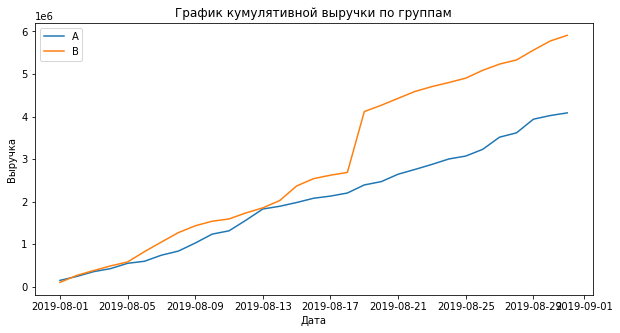

In [12]:
datesGroups = orders[['date', 'group']].drop_duplicates()

ordersAggregated = datesGroups.apply(
    lambda x: orders[
        np.logical_and(
            orders['date'] <= x['date'], orders['group'] == x['group']
        )
    ].agg(
        {
            'date': 'max',
            'group': 'max',
            'transactionId': 'nunique',
            'visitorId': 'nunique',
            'revenue': 'sum',
        }
    ),
    axis=1,
).sort_values(by=['date', 'group'])

visitorsAggregated = datesGroups.apply(
    lambda x: visitors[
        np.logical_and(
            visitors['date'] <= x['date'], visitors['group'] == x['group']
        )
    ].agg({'date': 'max', 'group': 'max', 'visitors': 'sum'}),
    axis=1,
).sort_values(by=['date', 'group'])

cumulativeData = ordersAggregated.merge(
    visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group']
)
cumulativeData.columns = [
    'date',
    'group',
    'orders',
    'buyers',
    'revenue',
    'visitors',
]
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group'] == 'A'][['date', 'revenue', 'orders']]
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group'] == 'B'][['date', 'revenue', 'orders']]

plt.figure(figsize=(10, 5))
# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')
# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')
plt.legend()
plt.title('График кумулятивной выручки по группам')
plt.xlabel('Дата')
plt.ylabel('Выручка')
plt.show()

По графикам можно наблюдать, что выручка группы В стабильно выше выручки группы А. Также заметен резкий скачок группы В примерно 18 августа, скорее всего из-за какого-то крупного заказа.

### График кумулятивного среднего чека по группам.

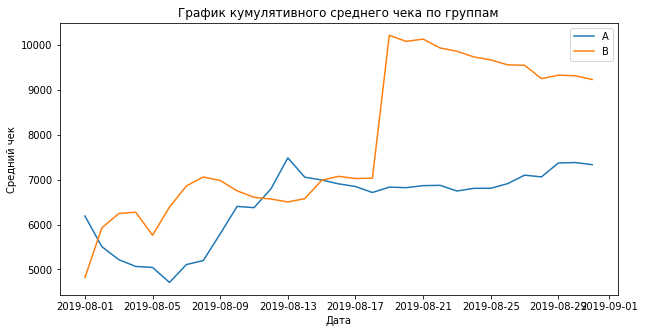

In [13]:
plt.figure(figsize=(10, 5))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.legend()
plt.title('График кумулятивного среднего чека по группам')
plt.xlabel('Дата')
plt.ylabel('Средний чек')
plt.show()

В период примерно с 10 по 14 августа средний чек группы В опустился ниже среднего чека группы А. И опять же резкое движение чека группы В вверх 18 августа, подтверждающее наличие крупного заказа в тот день.

### График относительного изменения кумулятивного среднего чека группы B к группе A.

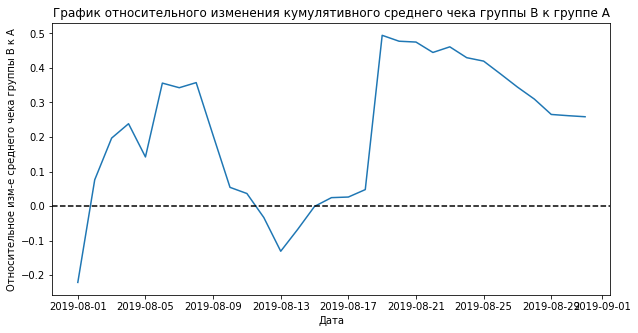

In [14]:
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
plt.figure(figsize=(10, 5))
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/ (mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA']) - 1)
plt.axhline(y=0, color='black', linestyle='--')
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A')
plt.xlabel('Дата')
plt.ylabel('Относительное изм-е среднего чека группы В к А')
plt.show()

Мы видим, как сильно меняются значения в определенные даты. Веротяно из-за аномальных заказов

### График кумулятивного среднего количества заказов на посетителя по группам.

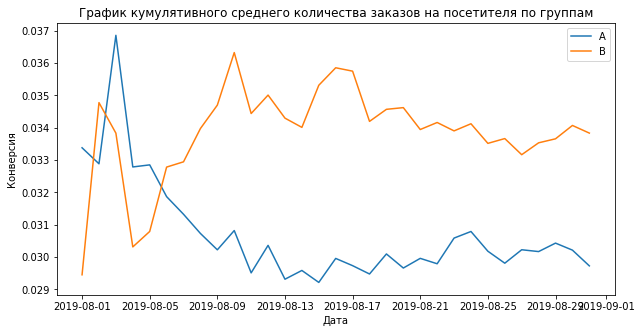

In [15]:
plt.figure(figsize=(10, 5))
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']
cumulativeDataA = cumulativeData[cumulativeData['group'] == 'A']
cumulativeDataB = cumulativeData[cumulativeData['group'] == 'B']

plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend()
plt.title('График кумулятивного среднего количества заказов на посетителя по группам')
plt.xlabel('Дата')
plt.ylabel('Конверсия')
plt.show()

Кумулятивная среднее количество заказов на посетителя группы В стабильно выше, чем у группы А.

### График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A.

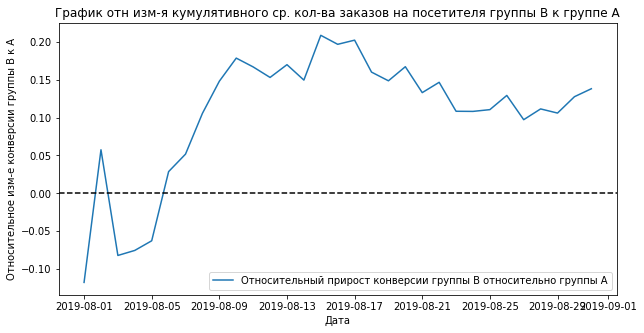

In [16]:
mergedCumulativeConversions = ( cumulativeDataA[['date','conversion']]
    .merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
                              )
plt.figure(figsize=(10, 5))
plt.plot(mergedCumulativeConversions['date'], 
        mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1,
        label="Относительный прирост конверсии группы B относительно группы A")
plt.legend()
plt.axhline(y=0, color='black', linestyle='--')
plt.title('График отн изм-я кумулятивного ср. кол-ва заказов на посетителя группы B к группе A')
plt.xlabel('Дата')
plt.ylabel('Относительное изм-е конверсии группы В к А')
plt.show()

Почти с самого начала конверсия группы В выше группы А и преимущество продожает колебаться в районе 10-15%

### Точечный график количества заказов по пользователям.

       visitorId  transactions
1023  4256040402            11
591   2458001652            11
569   2378935119             9
487   2038680547             8
44     199603092             5
744   3062433592             5
55     237748145             5
917   3803269165             5
299   1230306981             5
897   3717692402             5


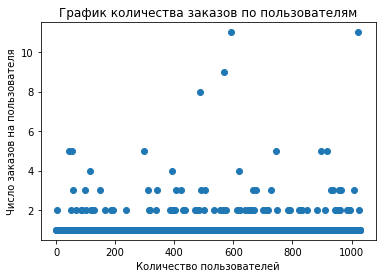

In [17]:
ordersByUsers = (
    orders.groupby('visitorId', as_index=False)
    .agg({'transactionId': 'nunique'})
)
ordersByUsers.columns = ['visitorId', 'transactions']

print(ordersByUsers.sort_values(by='transactions', ascending=False).head(10))

# серия из чисел от 0 до количества наблюдений в ordersByUsers
x_values = pd.Series(range(0, len(ordersByUsers)))
plt.scatter(x_values, ordersByUsers['transactions'])
plt.title('График количества заказов по пользователям')
plt.xlabel('Количество пользователей')
plt.ylabel('Число заказов на пользователя')
plt.show()

Основная масса пользователей делает 1-2 заказа.

### 95-й и 99-й перцентили количества заказов на пользователя.

In [18]:
print(np.percentile(ordersByUsers['transactions'], [90, 95, 99]))

[1. 2. 4.]


То есть всего 5% пользователей делают больше 2 заказов, и 1% пользователей делает более 4 заказов.  Тех, кто совершил от 2 заказов и более будем считать за аномальных.

### Точечный график стоимостей заказов.

count    1.197000e+03
mean     8.348006e+03
std      3.919113e+04
min      5.000000e+01
25%      1.220000e+03
50%      2.978000e+03
75%      8.290000e+03
max      1.294500e+06
Name: revenue, dtype: float64


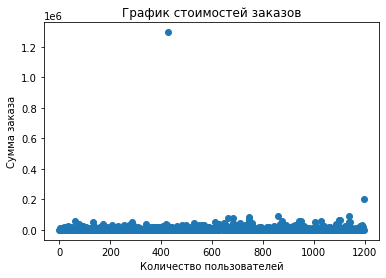

In [19]:
x_values = pd.Series(range(0, len(orders['revenue'])))
print(orders['revenue'].describe())

plt.scatter(x_values, orders['revenue'])
plt.title('График стоимостей заказов')
plt.xlabel('Количество пользователей')
plt.ylabel('Сумма заказа')
plt.show()

В большинстве случаев стоимость заказов менее 10 тысяч. Виден 1 заказ размером более 1.2 млн - вот он тот самый выброс в группе В

### 95-й и 99-й перцентили стоимости заказов.

In [20]:
print(np.percentile(orders['revenue'], [90, 95, 99]))

[18168.  28000.  58233.2]


90% заказов суммой до 18168, заказы от 28000 будем считать аномальными.

### Статистическая значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным. 

In [21]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'visitorId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

print(data.head(5))

# Создадим переменные ordersByUsersA и ordersByUsersB со столбцами ['visitorId', 'transactionId']. 
# В них для пользователей, которые заказывали хотя бы 1 раз, укажем число совершённых заказов. 
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['visitorId', 'orders']  
    
ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersB.columns = ['visitorId', 'orders']

        date  ordersPerDateA  revenuePerDateA  ordersPerDateB  \
0 2019-08-01              24           148579              20   
1 2019-08-02              20            93822              23   
2 2019-08-03              24           112473              16   
3 2019-08-04              16            70825              16   
4 2019-08-05              25           124218              23   

   revenuePerDateB  ordersCummulativeA  revenueCummulativeA  \
0           101217                  24               148579   
1           165531                  44               242401   
2           114248                  68               354874   
3           108571                  84               425699   
4            92428                 109               549917   

   ordersCummulativeB  revenueCummulativeB  visitorsPerDateA  \
0                  20               101217               719   
1                  43               266748               619   
2                  59               38

Сформулируем гипотезы:
- Н0 : статистически значимых различий в конверсии между группами нет
- Н1 : статистически значимые различия в конверсии между группами есть
    

In [22]:
# Объявим переменные sampleA и sampleB, в которых пользователям из разных групп будет соответствовать количество заказов. 
# Тем, кто ничего не заказал, будут соответствовать нули. 
sampleA = pd.concat(
    [ordersByUsersA['orders'],
    pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])),
    name='orders')],
    axis=0)

sampleB = pd.concat(
    [ordersByUsersB['orders'],
    pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])),
    name='orders')],
    axis=0)

# Применим критерий и отформатируем p-value, округлив его до трёх знаков после запятой.
print("{0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))
# Выведем относительный прирост среднего числа заказов группы B.
print("{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))

0.017
0.138


Таким образом, по сырым данным значение p-value 0.017, что меньше уровня статистической значимости, значит, гипотезу о том, что различий в среднем количестве заказов на посетителя между группами нет (H0), отвергаем. Относительная разница в конверсии между группами В и А составила 13,8%.

### Статистическая значимость различий в среднем чеке заказа между группами по «сырым» данным.

Гипотезы:
- Н0 : статистически значимых различий в среднем чеке между группами нет
- Н1 : статистически значимые различия в среднем чеке между группами есть

In [23]:
# Чтобы рассчитать статистическую значимость различий в среднем чеке, 
# передадим критерию mannwhitneyu() данные о выручке с заказов. 
print('{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
# А ещё найдём относительные различия в среднем чеке между группами.
print("{0:.3f}".format(orders[orders['group'] == 'B']['revenue'].mean() / orders[orders['group'] == 'A']['revenue'].mean() - 1))

0.729
0.259


P-value значительно больше 0.05, статистически значимых отличий между средними чеками групп нет (не удалось отвергнуть H0). Относительное различие между чеками почти 26%.

### Статистическая значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным. 

In [24]:
# Сделаем срезы пользователей с числом заказов больше 3 — usersWithManyOrders 
# и пользователей, совершивших заказы дороже 28 000 — usersWithExpensiveOrders. 
# Объединим их в таблице abnormalUsers. 
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 2]['visitorId'],
        ordersByUsersB[ordersByUsersB['orders'] > 2]['visitorId']
    ],
    axis = 0
)

usersWithExpensiveOrders = orders[orders['revenue'] > 28000]['visitorId']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(abnormalUsers.head())
print(len(abnormalUsers))

1099    148427295
18      199603092
928     204675465
23      237748145
37      249864742
Name: visitorId, dtype: int64
74


Также выдвинем гипотезы
- Н0 : по очщенным данным статистически значимых различий в конверсии между группами нет
- Н1 : статистически значимые различия в конверсии между группами есть

In [25]:
# Посчитаем статистическую значимость различий в среднем количестве заказов между группами теста по очищенным данным. 
# Сначала подготовим выборки количества заказов по пользователям по группам теста
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['visitorId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
        0, index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
        ),
        name='orders',
        ),
    ],
    axis=0,
)
    
sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['visitorId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
        0, index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
        ),
        name='orders',
        ),
    ],
    axis=0,
)

print('{0:.3f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('{0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

0.013
0.173


Как и в случае с сырыми данными, статистическая значимость достигнута (отвергаем H0). Группа В начительно лучше группы А.

### Статистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным.

Гипотезы:
- Н0 : по очищенным данным статистически значимых различий в среднем чеке между группами нет
- Н1 : статистически значимые различия в среднем чеке между группами есть

In [26]:
# Так же посчитаем статистическую значимость различий в среднем количестве заказов между группами теста по очищенным данным.
print(
    '{0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

print(
    "{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
)

0.738
-0.020


Нет статистически значимого различия по среднему чеку между группами ни по «сырым», ни по данным после фильтрации аномалий. А вот разница сократилась до 2%.

### Результаты теста.

Тест можно остановить и признать его успешным. По реузльатам теста мы увидели, что куммулятивная выручка группы В стабильно выше выручки группы А. То же самое можно сказать и о конверсии: группа В опережает группу А.

При проведении теста было обнаружено, что гипотеза о равенстве конверсии между группами отвергнута: относительная разница конверсии группы В по очищенным данным на 14.8% больше, чем в группе А.

Гипотеза об отсутствии различий в сумме среднего чека между группами не была отвергнута, относительная разница между группами составила 2% после исключения выбросов.

## Общий вывод

В ходе исследования с помощью фреймворка RICE была выделена наиболее приоритетная гипотеза №8: "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок".
По результатам А/В-теста было установлено отсутствие отличий в среднем чеке групп, но обнаружено, что выручка и конверсия группы В превосходит значения группы А. Было принято решение остановить тест и признать его успешным.